In [ ]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [196]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Démontrons que le changement de prix sur 15minutes suit une loi de Pareto.

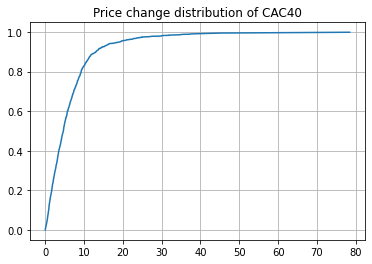

In [ ]:
def plot_distribution(tick, label="", normalise=False):
    # CREATE TICKER INSTANCE
    ticker = yf.Ticker(tick)

    # GET TODAYS DATE AND CONVERT IT TO A STRING WITH YYYY-MM-DD FORMAT (YFINANCE EXPECTS THAT FORMAT)
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(50)).strftime('%Y-%m-%d')

    # GET DATAFRAME
    df = ticker.history(start=start_date,end=end_date, interval="15m")
    df['Price Change'] = abs(df['Close'].diff())

    # PLOTTING
    x = np.array(sorted(df['Price Change'][df['Price Change']>0].dropna()))
    if normalise:
        x = 100*x/max(x)
    n = len(x)
    y = [i/n for i in range(n)]
    plt.plot(x, y, label=label)

plot_distribution("^FCHI")
plt.title("Price change distribution of CAC40")
plt.grid()

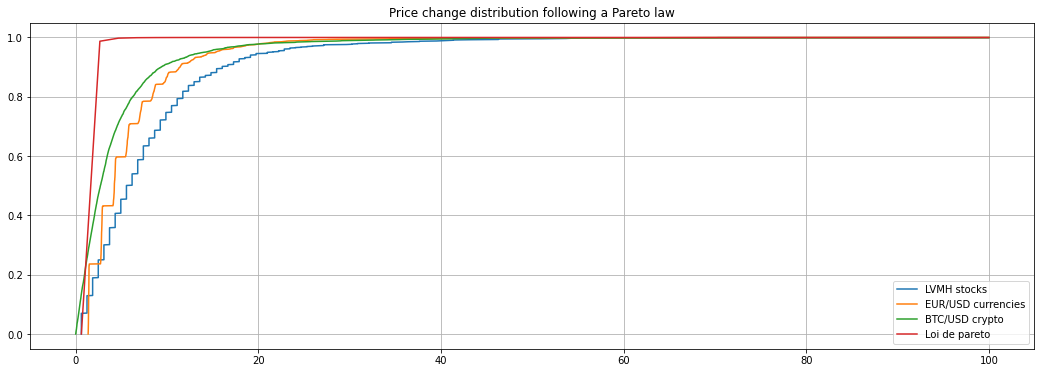

In [ ]:
plt.figure(figsize=(18, 6))

plot_distribution("MC.PA", label="LVMH stocks", normalise=True)
plot_distribution("EURUSD=X", label="EUR/USD currencies", normalise=True)
plot_distribution("BTC-USD", label="BTC/USD crypto", normalise=True)

x = np.linspace(0.617132781505608, 100)
y = [1-(0.617132781505608/x_)**3 for x_ in x]
plt.plot(x, y, label="Loi de pareto")

plt.title("Price change distribution following a Pareto law")
plt.grid()
plt.legend()

# Création du modèle

In [197]:
np.random.seed(seed=2)
class simulation:
    """
    Cette classe permet de créer la simulation décrite dans l'article :
    BUBBLES, CRASHES AND INTERMITTENCY IN AGENT BASED MARKET MODELS
    de Irene Giardina et Jean-Philippe Bouchaud
    décrit en 2018
    """
    # Nous déclarons ci-dessous les constantes de la classe
    S = 3 # Le nombre de stratégie (sachant que 1 stratégie est l'inactivité)
    m = 5 # La quantité de mémoire des agents
    g = 0.005 # La fraction d'action acheté ou vendu
    f = 0.05 # Le niveau de confiance
    N = 1_001 # Le nombre d'agent
    beta = 1-1e-2 # La mémoire du score

    def __init__(self, P, g_sur_l=0.1, alpha=1-1e-4, rho=0.02, phi=3_003, pi=0):
        self.l = self.g / g_sur_l # Lambda
        self.P = P #Polarisation 
        self.alpha = alpha # 0.04
        self.phi = phi # Le nombre total d'action en circulation (Quelle valeure faut-il mettre ?)
        self.rho = rho # 0.000054255 # 2% d'intéret (Quelle valeure faut il mettre ? Regarder la croissance de la courbe Figure 1 ?)
        self.pi = pi
        
        self.epsilon = [
            [self.creation_strategie(self.m) for _ in range(self.S-1)] + [lambda x: 0]
            for _ in range(self.N)
        ] # Les S stratégies pour les N agents
        self.theta = np.random.random(self.N) # Le nombre de stock
        self.B = np.random.random(self.N) # Le nombre de bond
        self.X = (np.random.random(self.m+2)/100_000 + 5).tolist() # Les prix initialisé de façon aléatoire
        self.score = [
            [0 for _ in range(self.S)]
            for _ in range(self.N)
        ] # Les scores à t

    def creation_strategie(self, m):
        # Il y a 2^m I_t (information) possible
        # L'information est une suite de m élément 1 ou -1
        # Je vais donc représenter I_t est donc une suite de binaire 1:1 et 0:-1
        # Pour simplifier la manipulation de I_t je vais prendre sa représentation décimale
        # I_t est donc à valeure dans [0, 2^m-1]

        # Choisissons combien d'informations vont être acheteuse
        nb_acheter = np.random.choice(a=2**m)
        # Choisissons les possibilités acheteuses, d'après la variable self.P
        # P=1 tendance à Trend Following
        # P=-1 tendance à Mean Reverting
        liste_acheter = []
        for info in range(2**m): 
            nb_positif = (bin(info)[2:]).count("1")
            nb_negatif = self.m - nb_positif
            M = (nb_positif-nb_negatif)/self.m
            if np.random.random() < (1+self.P*M)/2:
                liste_acheter.append(info)

        # Créons la fonction epsilon_i(I_t)
        def epsilon_i(I_t):
            if I_t in liste_acheter:
                return 1
            else:
                return -1
        return epsilon_i
    
    def information(self, t=0):
        I_t = 0
        for i in range(self.m):
            if (np.log(self.X[-1-i+t]/self.X[-2-i+t]) - self.rho) > 0:
                I_t += 2**i
        return I_t

    def calcul_score(self):
        info = self.information(t=-1)
        r = np.log(self.X[-1]/self.X[-2])
        for i in range(self.N): # Calcul des scores de l'agent i
            for alpha in range(self.S-1): # Calcul des scores de la stratégies alpha
                arg1 = (1-self.beta)*self.score[i][alpha]
                arg2 = self.beta*self.epsilon[i][alpha](info)*(r-self.rho)
                self.score[i][alpha] = arg1 + arg2

    def r_barre(self):
        r_barre = 0
        t = len(self.X)
        for t_ in range(t-1):
            r_barre += (self.alpha**(t-t_-1))*np.log(self.X[t_+1]/self.X[t_])
        r_barre = r_barre / (1-self.alpha)
        pf = min(
            1,
            self.f * abs(r_barre-self.rho) / self.rho
        )
        return r_barre, pf

    def simulation(self):
        # Calcul du score
        self.calcul_score()
        alpha_star = np.argmax(self.score, axis=1) # Les meilleurs stratégies
        info = self.information()
        r_barre, pf = self.r_barre()
        choix = []
        # Calcul du choix des agents
        ag = 0
        pf_count = 0
        action_count = 0
        for i in range(self.N):
            random = np.random.random()
            if random < self.pi: # L'agent fait un truc random
                choix.append(np.random.randint(3)-1)
            elif random < (1-self.pi)*pf: # Probas fondamentaliste
                pf_count += 1
                if r_barre > self.rho:
                    choix.append(-1)
                else:
                    choix.append(1)                
            else:
                ag += 1
                action = self.epsilon[i][alpha_star[i]](info)
                action_count += action
                choix.append(action)
        # Calcul des quantités par agents
        quantite = []
        choix_moins  = 0
        choix_plus  = 0
        for i in range(self.N):
            if choix[i] == 1:
                choix_plus += 1
                quantite.append(
                    self.g*self.B[i]/self.X[-1]
                )
            elif choix[i] == 0:
                quantite.append(0)
            else:
                choix_moins += 1
                quantite.append(
                    -self.g*self.theta[i]
                )
        # Calcul des quantités globale
        q_plus = 0
        q_moins = 0
        for q in quantite:
            if q > 0:
                q_plus += q
            elif q < 0:
                q_moins -= q
        q_plus = q_plus/self.phi
        q_moins = q_moins/self.phi
        q = q_plus-q_moins

        self.X.append((q/self.l + 1)*self.X[-1]) # Mise à jour du prix
        # Calcul des volontés d'échange
        q_tilde = q_plus * self.X[-2] / self.X[-1]
        if q_moins < q_tilde:
            phi_plus = q_moins/q_tilde
        else:
            phi_plus = 1
        if q_tilde < q_moins:
            phi_moins = q_tilde/q_moins
        else:
            phi_moins = 1
        # phi_plus = min(1, q_moins/q_tilde)
        # phi_moins = min(1, q_tilde/q_moins)
        # Calcul de l'échange réel
        delta_theta = []
        for q in quantite:
            if q > 0:
                delta_theta.append(q*phi_plus)
            elif q < 0:
                delta_theta.append(q*phi_moins)
            else:
                delta_theta.append(0)
        # print(f"action_count : {action_count} ag : {ag} pf_count : {pf_count} pf: {pf} r_barre {r_barre} +1 : {choix_plus} -1 : {choix_moins} {phi_plus} {phi_moins} q_plus : {q_plus}, q_moins : {q_moins}, X[-2] : {self.X[-2]}, X[-1] : {self.X[-1]}, q_tilde : {q_tilde}")
        
        for i in range(self.N):
            self.theta[i] = self.theta[i] + delta_theta[i]
            self.B[i] = self.B[i]*(1+self.rho) - delta_theta[i]*self.X[-1]







In [237]:
# Random, fully random
sim = simulation(P=0, phi=50, alpha=1-1e-4, rho=1e-3, pi=1)
sim = simulation(P=0, phi=3_000, alpha=1-1e-4, rho=1e-3, pi=1)

In [180]:
# P, g_sur_l=0.1, alpha=1-1e-4, rho=0.02, phi=3_003, pi=0
# Périodique
sim = simulation(P=0, phi=50, alpha=1e-2, rho=1e-3, pi=0)

In [183]:
# Intermittent
sim = simulation(P=0, g_sur_l=0.6, phi=50, alpha=1e-2, rho=1e-3, pi=0)

In [186]:
# Stable
sim = simulation(P=-0.2, g_sur_l=0.6, phi=50, alpha=1e-2, rho=1e-3, pi=0)

In [238]:
%%time
for _ in range(6000):
    sim.simulation()

CPU times: user 1min 12s, sys: 15.3 ms, total: 1min 12s
Wall time: 1min 18s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


Text(0.5, 1.0, 'test$test\\ \\frac{a}{b}$')

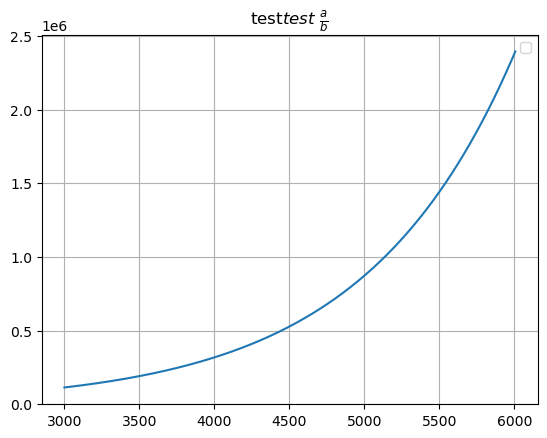

In [189]:
%time
# plt.figure(figsize=(18, 9))
# plt.yscale('log')
plt.plot(range(3_000, 3_000 + len(sim.X[3000:])), sim.X[3000:])
plt.grid()
plt.legend()
plt.title(a+ r"$test\ \frac{a}{b}$")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'test$test\\ \\frac{a}{b}$')

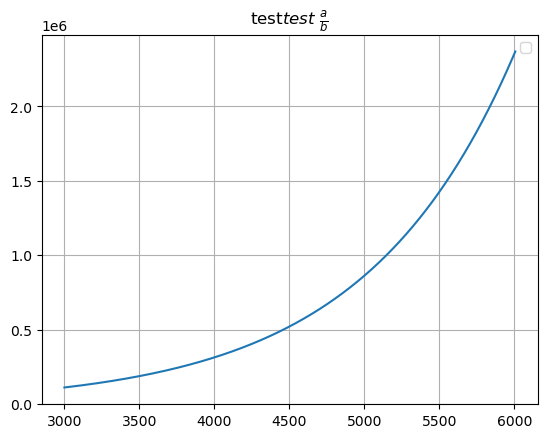

In [185]:
# plt.figure(figsize=(18, 9))
# plt.yscale('log')
plt.plot(range(3_000, 3_000 + len(sim.X[3000:])), sim.X[3000:])
plt.grid()
plt.legend()
plt.title(a+ r"$test\ \frac{a}{b}$")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'test$test\\ \\frac{a}{b}$')

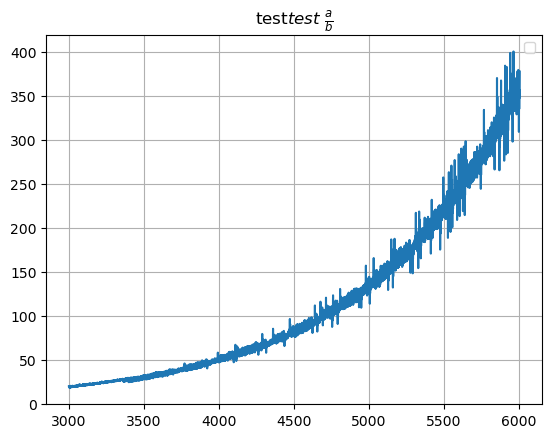

In [182]:
# plt.figure(figsize=(18, 9))
# plt.yscale('log')
plt.plot(range(3_000, 3_000 + len(sim.X[3000:])), sim.X[3000:])
plt.grid()
plt.legend()
plt.title(a+ r"$test\ \frac{a}{b}$")

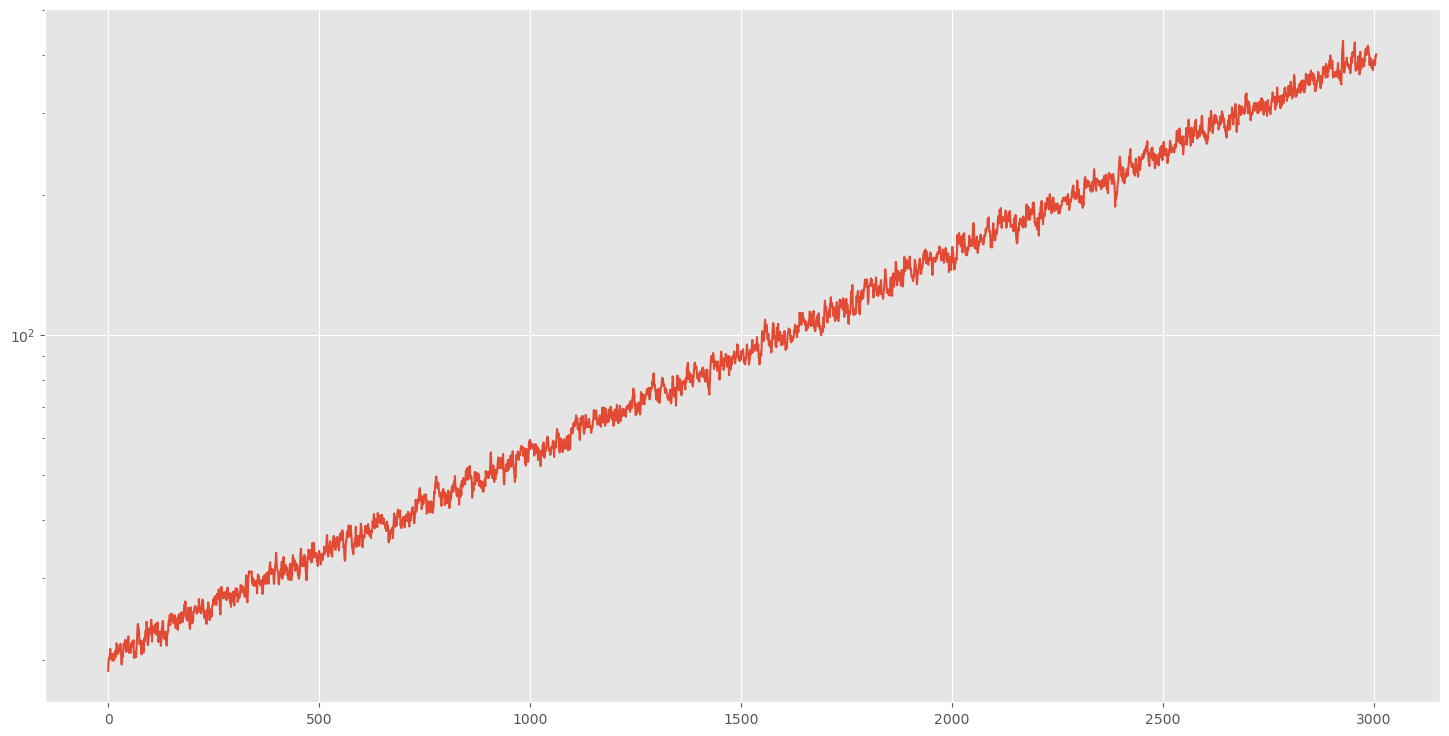

In [236]:
plt.figure(figsize=(18, 9))
plt.plot(sim.X[3_000:])
plt.yscale('log')
plt.grid()
plt.grid()

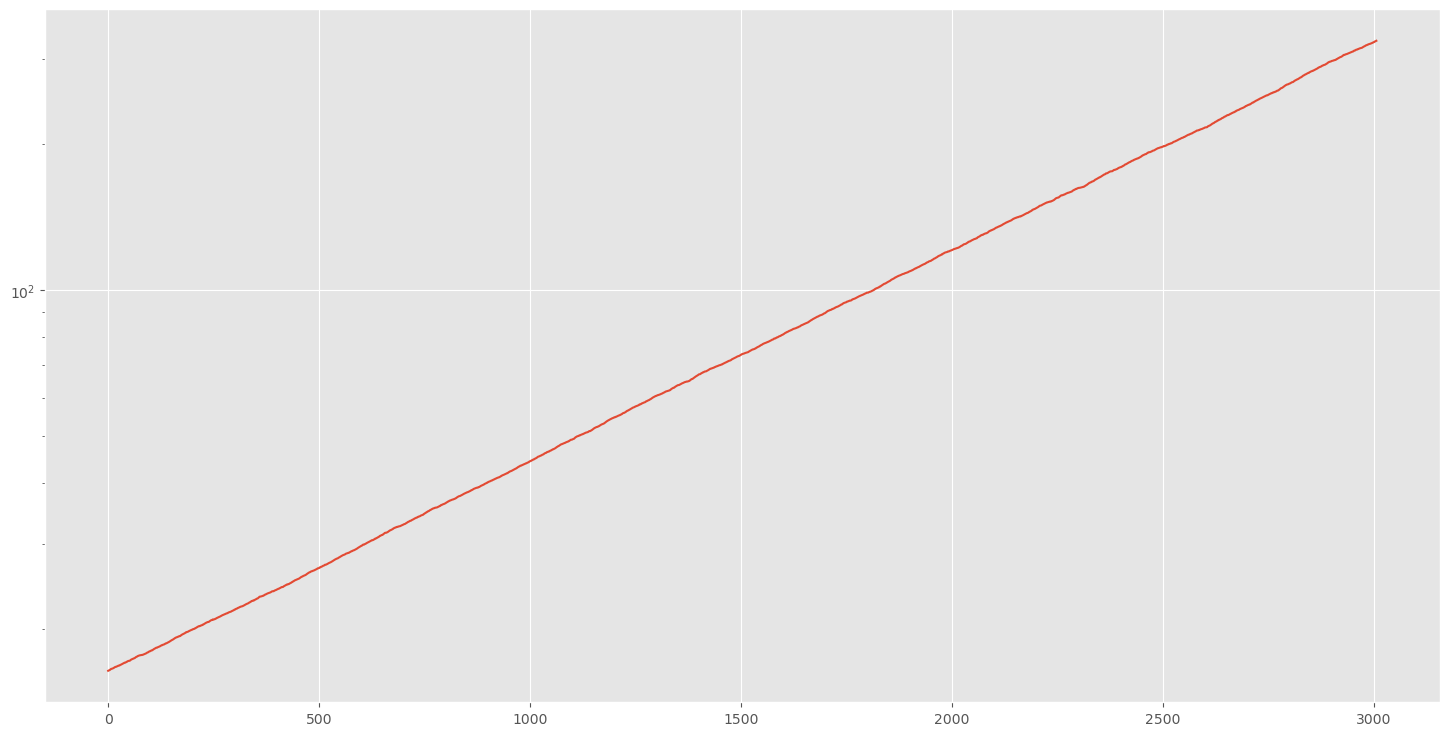

In [239]:
plt.figure(figsize=(18, 9))
plt.plot(sim.X[3_000:])
plt.yscale('log')
plt.grid()
plt.grid()